In [ ]:
!pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.1 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download("brown")
nltk.download("universal_tagset")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import sklearn

import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [ ]:
# reading the Brown tagged sentences
brown= list(nltk.corpus.brown.tagged_sents(tagset='universal'))

In [ ]:
# first few tagged sentences
print(brown[:2])
print(len(brown))

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [ ]:
nltk_data = brown

In [ ]:
nltk_data[1]

[('The', 'DET'),
 ('jury', 'NOUN'),
 ('further', 'ADV'),
 ('said', 'VERB'),
 ('in', 'ADP'),
 ('term-end', 'NOUN'),
 ('presentments', 'NOUN'),
 ('that', 'ADP'),
 ('the', 'DET'),
 ('City', 'NOUN'),
 ('Executive', 'ADJ'),
 ('Committee', 'NOUN'),
 (',', '.'),
 ('which', 'DET'),
 ('had', 'VERB'),
 ('over-all', 'ADJ'),
 ('charge', 'NOUN'),
 ('of', 'ADP'),
 ('the', 'DET'),
 ('election', 'NOUN'),
 (',', '.'),
 ('``', '.'),
 ('deserves', 'VERB'),
 ('the', 'DET'),
 ('praise', 'NOUN'),
 ('and', 'CONJ'),
 ('thanks', 'NOUN'),
 ('of', 'ADP'),
 ('the', 'DET'),
 ('City', 'NOUN'),
 ('of', 'ADP'),
 ('Atlanta', 'NOUN'),
 ("''", '.'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('manner', 'NOUN'),
 ('in', 'ADP'),
 ('which', 'DET'),
 ('the', 'DET'),
 ('election', 'NOUN'),
 ('was', 'VERB'),
 ('conducted', 'VERB'),
 ('.', '.')]

In [ ]:
# split data into training and validation and test set
train_set,test_set = train_test_split(nltk_data,train_size=0.85,test_size=0.15,random_state=101)
train_set,val_set = train_test_split(nltk_data,train_size=0.80,test_size=0.20,random_state=101)

In [ ]:
# extract features from a given sentence
def word_features(sent, i):
    word = sent[i][0]
    pos = sent[i][1]

    # first word
    if i==0:
        prevword = '<START>'
        prevpos = '<START>'
    else:
        prevword = sent[i-1][0]
        prevpos = sent[i-1][1]

    # first word
    if i==0 or i==1:
        prev2word = '<START>'
        prev2pos = '<START>'
    else:
        prev2word = sent[i-2][0]
        prev2pos = sent[i-2][1]

    # last word
    if i == len(sent)-1:
        nextword = '<END>'
        nextpos = '<END>'
    else:
        nextword = sent[i+1][0]
        nextpos = sent[i+1][1]

    # suffixes and prefixes
    pref_1, pref_2, pref_3, pref_4 = word[:1], word[:2], word[:3], word[:4]
    suff_1, suff_2, suff_3, suff_4 = word[-1:], word[-2:], word[-3:], word[-4:]

    #rule_state = rule_based_tagger.tag([word])[0][1]

    return {'word':word,
            'prevword': prevword,
            'prevpos': prevpos,
            'nextword': nextword,
            'nextpos': nextpos,
            'suff_1': suff_1,
            'suff_2': suff_2,
            'suff_3': suff_3,
            'suff_4': suff_4,
            'pref_1': pref_1,
            'pref_2': pref_2,
            'pref_3': pref_3,
            'pref_4': pref_4,
            'prev2word': prev2word,
            'prev2pos': prev2pos
           }

In [ ]:
# let's check if our word feature is working correctly:
print(train_set[0][0:5])

word_features(train_set[0],3)

[('A', 'DET'), ('Newfoundland', 'NOUN'), ('sat', 'VERB'), ('solemnly', 'ADV'), ('beside', 'ADP')]


{'word': 'solemnly',
 'prevword': 'sat',
 'prevpos': 'VERB',
 'nextword': 'beside',
 'nextpos': 'ADP',
 'suff_1': 'y',
 'suff_2': 'ly',
 'suff_3': 'nly',
 'suff_4': 'mnly',
 'pref_1': 's',
 'pref_2': 'so',
 'pref_3': 'sol',
 'pref_4': 'sole',
 'prev2word': 'Newfoundland',
 'prev2pos': 'NOUN'}

In [ ]:
# defining a few more functions to extract featrues, postags and words from sentences

def sent2features(sent):
    return [word_features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [postag for word, postag in sent]

def sent2tokens(sent):
    return [word for word, postag in sent]

In [ ]:
 # create training, validation and test sets
X_train = [sent2features(s) for s in train_set]
y_train = [sent2labels(s) for s in train_set]

X_valid = [sent2features(s) for s in val_set]
y_valid = [sent2labels(s) for s in val_set]

X_test = [sent2features(s) for s in test_set]
y_test = [sent2labels(s) for s in test_set]

In [ ]:
# check the train set produced
print(X_train[0][0:10])

[{'word': 'A', 'prevword': '<START>', 'prevpos': '<START>', 'nextword': 'Newfoundland', 'nextpos': 'NOUN', 'suff_1': 'A', 'suff_2': 'A', 'suff_3': 'A', 'suff_4': 'A', 'pref_1': 'A', 'pref_2': 'A', 'pref_3': 'A', 'pref_4': 'A', 'prev2word': '<START>', 'prev2pos': '<START>'}, {'word': 'Newfoundland', 'prevword': 'A', 'prevpos': 'DET', 'nextword': 'sat', 'nextpos': 'VERB', 'suff_1': 'd', 'suff_2': 'nd', 'suff_3': 'and', 'suff_4': 'land', 'pref_1': 'N', 'pref_2': 'Ne', 'pref_3': 'New', 'pref_4': 'Newf', 'prev2word': '<START>', 'prev2pos': '<START>'}, {'word': 'sat', 'prevword': 'Newfoundland', 'prevpos': 'NOUN', 'nextword': 'solemnly', 'nextpos': 'ADV', 'suff_1': 't', 'suff_2': 'at', 'suff_3': 'sat', 'suff_4': 'sat', 'pref_1': 's', 'pref_2': 'sa', 'pref_3': 'sat', 'pref_4': 'sat', 'prev2word': 'A', 'prev2pos': 'DET'}, {'word': 'solemnly', 'prevword': 'sat', 'prevpos': 'VERB', 'nextword': 'beside', 'nextpos': 'ADP', 'suff_1': 'y', 'suff_2': 'ly', 'suff_3': 'nly', 'suff_4': 'mnly', 'pref_1':

In [ ]:
y_train[0][0:10]

['DET', 'NOUN', 'VERB', 'ADV', 'ADP', 'DET', 'NOUN', 'PRT', 'DET', 'NOUN']

In [ ]:
# fitting crf with arbitrary hyperparameters
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.01, c2=0.1,
    max_iterations=100)

In [ ]:
labels = list(crf.classes_)

In [ ]:
# make predictions
y_pred = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred,
                      average='weighted', labels=labels)

0.9815135950857892

In [ ]:
# class-wise scores
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           .      1.000     1.000     1.000     29701
           X      0.953     0.813     0.878       300
         ADJ      0.950     0.940     0.945     16852
         ADP      0.981     0.985     0.983     29177
         ADV      0.952     0.941     0.946     11383
        VERB      0.983     0.983     0.983     37018
         DET      0.994     0.996     0.995     27692
        CONJ      0.995     0.997     0.996      7655
        NOUN      0.979     0.984     0.982     55378
        PRON      0.992     0.989     0.990     10032
         PRT      0.954     0.951     0.952      6074
         NUM      0.988     0.992     0.990      2838

    accuracy                          0.982    234100
   macro avg      0.977     0.964     0.970    234100
weighted avg      0.982     0.982     0.982    234100



# Hyperparameter Tuning





In [ ]:
# hyperparameter tuning

# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

# parameters to tune
params_space = {
    'c1': [0.01, 0.1, 1],
    'c2': [0.01, 0.1, 1]
}

# use the same metric for evaluation
f1_scorer = scorers.make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [ ]:
# instantiate a GridSearchCV object
rs = GridSearchCV(crf,
                  params_space,
                  cv=3,
                  verbose=1,
                  n_jobs=3,
                  scoring=f1_scorer,
                  return_train_score=True
                  )
# fit
rs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=CRF(algorithm='lbfgs', all_possible_transitions=True,
                           max_iterations=100),
             n_jobs=3, param_grid={'c1': [0.01, 0.1, 1], 'c2': [0.01, 0.1, 1]},
             return_train_score=True,
             scoring=make_scorer(flat_f1_score, response_method='predict', average=weighted, labels=['DET', 'NOUN', 'VERB', 'ADV', 'ADP', 'PRT', '.', 'CONJ', 'ADJ', 'NUM', 'PRON', 'X']),
             verbose=1)

In [ ]:
# store CV results in a DF
cv_results = pd.DataFrame(rs.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_c1,param_c2,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,375.977068,22.608476,16.489519,2.139243,0.01,0.01,"{'c1': 0.01, 'c2': 0.01}",0.979098,0.977959,0.978218,0.978425,0.000488,4,0.998268,0.998244,0.998291,0.998268,0.000019
1,385.323343,6.592530,15.654680,0.303747,0.01,0.10,"{'c1': 0.01, 'c2': 0.1}",0.980240,0.979697,0.979608,0.979848,0.000279,1,0.996571,0.996550,0.996658,0.996593,0.000046
2,394.034503,6.573946,15.563076,0.777039,0.01,1.00,"{'c1': 0.01, 'c2': 1}",0.978161,0.978164,0.977680,0.978002,0.000228,7,0.986737,0.986881,0.986960,0.986859,0.000092
3,388.187107,2.904297,15.379797,0.460347,0.10,0.01,"{'c1': 0.1, 'c2': 0.01}",0.979897,0.979222,0.979079,0.979399,0.000357,3,0.997817,0.997770,0.997834,0.997807,0.000027
4,386.531090,6.630079,15.121816,0.162809,0.10,0.10,"{'c1': 0.1, 'c2': 0.1}",0.980139,0.979892,0.979471,0.979834,0.000276,2,0.995826,0.995821,0.995845,0.995831,0.000010
5,398.510912,3.931606,15.470693,0.416071,0.10,1.00,"{'c1': 0.1, 'c2': 1}",0.977847,0.978111,0.977482,0.977813,0.000258,8,0.985972,0.986146,0.986148,0.986089,0.000083
6,387.672417,6.434608,14.603106,0.418954,1.00,0.01,"{'c1': 1, 'c2': 0.01}",0.978603,0.978505,0.977935,0.978348,0.000295,5,0.984749,0.984917,0.985016,0.984894,0.000110
7,393.875328,4.692817,14.499397,0.208217,1.00,0.10,"{'c1': 1, 'c2': 0.1}",0.978329,0.978325,0.977655,0.978103,0.000317,6,0.983920,0.984003,0.984097,0.984007,0.000073
8,389.278452,4.357593,13.918250,0.997527,1.00,1.00,"{'c1': 1, 'c2': 1}",0.975802,0.976203,0.975316,0.975774,0.000363,9,0.979980,0.979893,0.980065,0.979979,0.000070


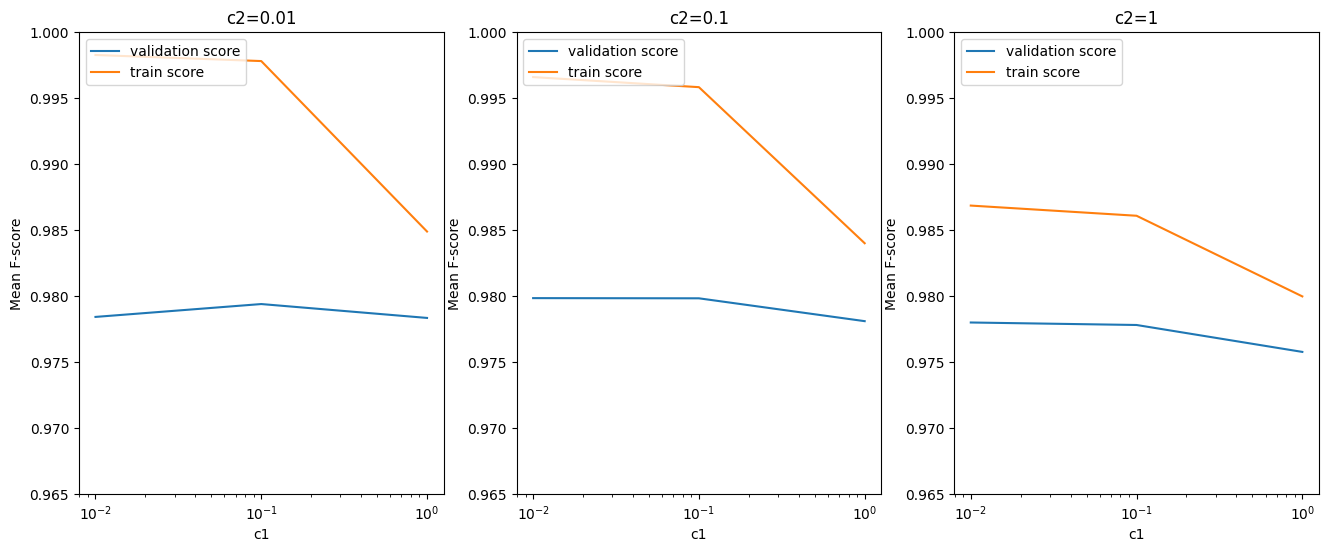

In [ ]:
# plotting CV results
# for each value of c2, make a plot of c1 versus train and test f1-score

plt.figure(figsize=(16,6))

for i, val in enumerate(params_space['c2']):

    # subplot 1/3/i
    plt.subplot(1, 3, i+1)
    c2_subset = cv_results[cv_results['param_c2']==val]

    plt.plot(c2_subset["param_c1"], c2_subset["mean_test_score"])
    plt.plot(c2_subset["param_c1"], c2_subset["mean_train_score"])
    plt.xlabel('c1')
    plt.ylabel('Mean F-score')
    plt.title("c2={0}".format(val))
    plt.ylim([0.965, 1])
    plt.legend(['validation score', 'train score'], loc='upper left')
    plt.xscale('log')

In [ ]:
# building a model with optimal hyperparams
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.01, c2=0.1,
    max_iterations=100)

In [ ]:
# save the model to a pickle file
import _pickle as cPickle

with open('tuned_crf_pos_tagger.pkl', 'wb') as clf:
    try:
        cPickle.dump(crf, clf)
    except Exception as e:
        print(e)
    finally:
        clf.close()

# Final Training

In [ ]:
# load the trained model
import _pickle as cPickle

with open('tuned_crf_pos_tagger.pkl', 'rb') as fid:
    crf = cPickle.load(fid)

In [ ]:
# make predictions on validation data
y_pred = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred,
                      average='weighted', labels=labels)


0.9815135950857892

In [ ]:
# class-wise scores on validation data
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           .      1.000     1.000     1.000     29701
           X      0.953     0.813     0.878       300
         ADJ      0.950     0.940     0.945     16852
         ADP      0.981     0.985     0.983     29177
         ADV      0.952     0.941     0.946     11383
        VERB      0.983     0.983     0.983     37018
         DET      0.994     0.996     0.995     27692
        CONJ      0.995     0.997     0.996      7655
        NOUN      0.979     0.984     0.982     55378
        PRON      0.992     0.989     0.990     10032
         PRT      0.954     0.951     0.952      6074
         NUM      0.988     0.992     0.990      2838

    accuracy                          0.982    234100
   macro avg      0.977     0.964     0.970    234100
weighted avg      0.982     0.982     0.982    234100



In [ ]:
# test data predictions
# make predictions on validation data
y_pred_test = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred_test,
                      average='weighted', labels=labels)

0.9816468075015065

In [ ]:
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report

# Flatten y_valid and y_pred
y_valid_flat = [label for sublist in y_valid for label in sublist]
y_pred_flat = [label for sublist in y_pred for label in sublist]

# Calculate precision, recall, and F1-score for each POS tag
precision, recall, f1_score, support = precision_recall_fscore_support(
    y_valid_flat, y_pred_flat, labels=sorted_labels, average=None
)
import numpy as np

# Calculate the average precision, recall, and F1-score
print(np.mean(precision))
print(np.mean(recall))
print(np.mean(f1_score))

# Calculate F0.5, F1, and F2 for each POS tag
f0_5 = fbeta_score(y_valid_flat, y_pred_flat, labels=sorted_labels, beta=0.5, average=None)
f1 = fbeta_score(y_valid_flat, y_pred_flat, labels=sorted_labels, beta=1.0, average=None)  # Equivalent to F1-score
f2 = fbeta_score(y_valid_flat, y_pred_flat, labels=sorted_labels, beta=2.0, average=None)
print(np.mean(f0_5))
print(np.mean(f1))
print(np.mean(f2))

# Calculate weighted precision, recall, F0.5, F1, and F2
precision_overall, recall_overall, _, _ = precision_recall_fscore_support(
    y_valid_flat, y_pred_flat, labels=sorted_labels, average='weighted'
)
f0_5_overall = fbeta_score(y_valid_flat, y_pred_flat, labels=sorted_labels, beta=0.5, average='weighted')
f1_overall = fbeta_score(y_valid_flat, y_pred_flat, labels=sorted_labels, beta=1.0, average='weighted')
f2_overall = fbeta_score(y_valid_flat, y_pred_flat, labels=sorted_labels, beta=2.0, average='weighted')

# Print overall metrics
print(f"Weighted Precision: {precision_overall:.6f}")
print(f"Weighted Recall: {recall_overall:6f}")
print(f"Weighted F0.5-Score: {f0_5_overall:.6f}")
print(f"Weighted F1-Score: {f1_overall:.6f}")
print(f"Weighted F2-Score: {f2_overall:.6f}")

# Print per POS tag precision, recall, F0.5, F1, and F2
print("\nPer POS Tag metrics:")
for i, label in enumerate(sorted_labels):
    print(f"{label}: Precision: {precision[i]:.3f}, Recall: {recall[i]:.3f}, F0.5: {f0_5[i]:.3f}, F1: {f1[i]:.3f}, F2: {f2[i]:.3f}")

# Optionally, print full classification report for more details
print("\nFull classification report:")
print(classification_report(y_valid_flat, y_pred_flat, labels=sorted_labels, digits=3))


0.9768268551388273
0.9640475013324913
0.9699695609080461
0.9739569930386803
0.9699695609080461
0.9663174799722386
Weighted Precision: 0.981502
Weighted Recall: 0.981551
Weighted F0.5-Score: 0.981503
Weighted F1-Score: 0.981514
Weighted F2-Score: 0.981533

Per POS Tag metrics:
.: Precision: 1.000, Recall: 1.000, F0.5: 1.000, F1: 1.000, F2: 1.000
X: Precision: 0.953, Recall: 0.813, F0.5: 0.921, F1: 0.878, F2: 0.838
ADJ: Precision: 0.950, Recall: 0.940, F0.5: 0.948, F1: 0.945, F2: 0.942
ADP: Precision: 0.981, Recall: 0.985, F0.5: 0.982, F1: 0.983, F2: 0.984
ADV: Precision: 0.952, Recall: 0.941, F0.5: 0.949, F1: 0.946, F2: 0.943
VERB: Precision: 0.983, Recall: 0.983, F0.5: 0.983, F1: 0.983, F2: 0.983
DET: Precision: 0.994, Recall: 0.996, F0.5: 0.995, F1: 0.995, F2: 0.996
CONJ: Precision: 0.995, Recall: 0.997, F0.5: 0.995, F1: 0.996, F2: 0.996
NOUN: Precision: 0.979, Recall: 0.984, F0.5: 0.980, F1: 0.982, F2: 0.983
PRON: Precision: 0.992, Recall: 0.989, F0.5: 0.991, F1: 0.990, F2: 0.989
PRT

Unique valid labels: {'ADJ', 'NUM', 'VERB', 'ADP', 'CONJ', 'NOUN', 'PRON', 'PRT', 'X', 'ADV', 'DET', '.'}
Unique predicted labels: {'ADJ', 'NUM', 'X', 'ADP', 'CONJ', 'NOUN', 'PRON', 'PRT', 'VERB', 'ADV', 'DET', '.'}
TAGS: ['.', 'X', 'ADJ', 'ADP', 'ADV', 'VERB', 'DET', 'CONJ', 'NOUN', 'PRON', 'PRT', 'NUM']


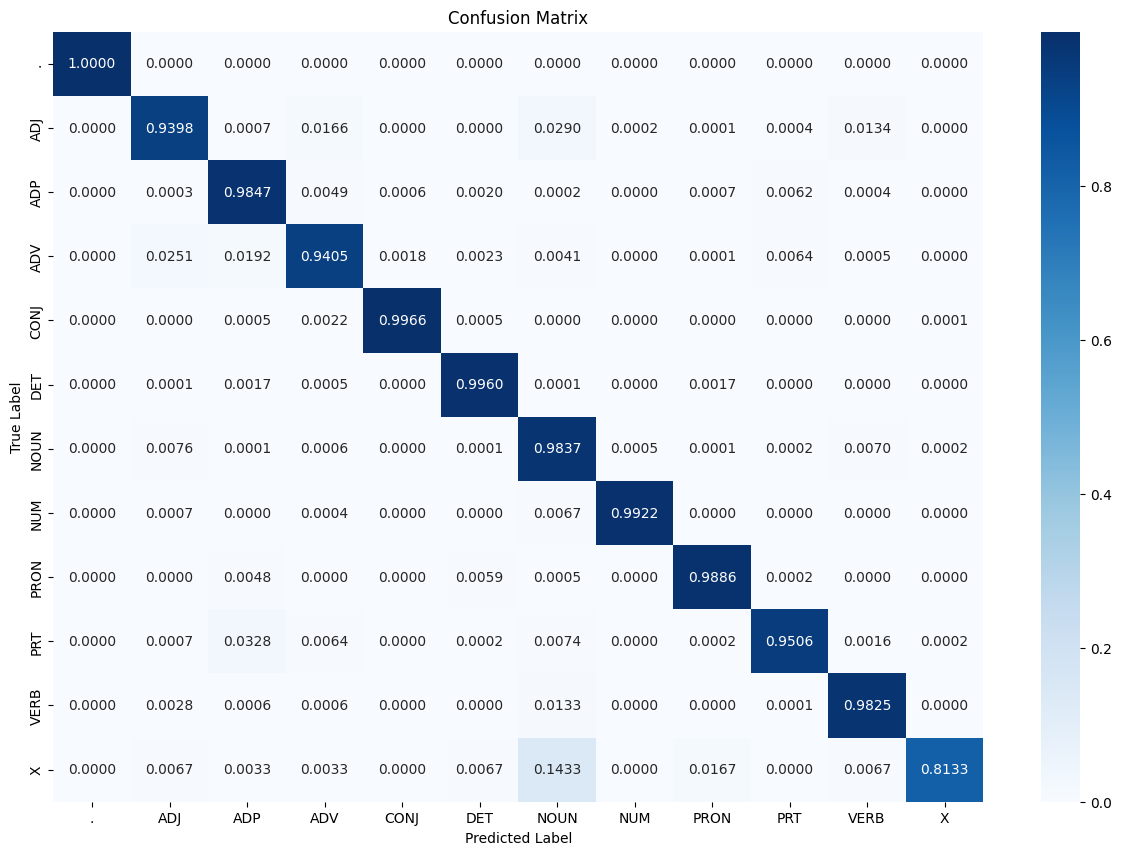

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten y_valid and y_pred
y_valid_flat = [label for sublist in y_valid for label in sublist]
y_pred_flat = [label for sublist in y_pred for label in sublist]

# Check the unique labels in y_valid_flat and y_pred_flat
unique_valid_labels = set(y_valid_flat)
unique_pred_labels = set(y_pred_flat)

# Define TAGS and N_TAGS
TAGS = sorted_labels  # Use the sorted labels from the model
N_TAGS = len(TAGS)    # Number of tags

print(f"Unique valid labels: {unique_valid_labels}")
print(f"Unique predicted labels: {unique_pred_labels}")
print(f"TAGS: {TAGS}")

# Create a consistent label list from the unique labels
consistent_tags = sorted(unique_valid_labels.union(unique_pred_labels))

# Calculate the normalized confusion matrix with consistent tags
conf_matrix = confusion_matrix(y_valid_flat, y_pred_flat, labels=consistent_tags, normalize='true')

# Function to plot confusion matrix
def plotCM(cm):
    df_cm = pd.DataFrame(cm, index=consistent_tags, columns=consistent_tags)
    plt.figure(figsize=(15, 10))
    sns.heatmap(df_cm, annot=True, fmt='.4f', cmap=plt.cm.Blues)  # Use .4f for four decimal places
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Plot the normalized confusion matrix
plotCM(conf_matrix)


# GUI

In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.0 MB/s eta 0:00:00


In [ ]:
import gradio as gr

# Function to make predictions on input text
def predict_pos_tags(input_text):
    # Tokenize input text
    tokens = input_text.split()

    # Create features for the input tokens
    features = [word_features([(token, '')], 0) for token in tokens]

    # Predict the POS tags
    predicted_tags = crf.predict([features])[0]

    # Return the tokens and their corresponding predicted tags
    return list(zip(tokens, predicted_tags))



# Create Gradio interface
interface = gr.Interface(
    fn=predict_pos_tags,
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentence..."),
    outputs=gr.Dataframe(headers=["Word", "POS Tag"], type="pandas"),
    title="POS Tagging with CRF",
    description="Enter a sentence to get its Part-of-Speech tags."
)

# Launch the interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://746e601079d3b08a89.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
